In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.31G/6.31G [05:26<00:00, 20.2MB/s]
100% 6.31G/6.31G [05:26<00:00, 20.7MB/s]


In [6]:
!unzip "/content/histopathologic-cancer-detection.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import sklearn

In [ ]:
full_train_df = pd.read_csv("train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
print("Train Size: {}".format(len(os.listdir('/content/train/'))))
print("Test Size: {}".format(len(os.listdir('/content/test/'))))

Train Size: 220025
Test Size: 57458


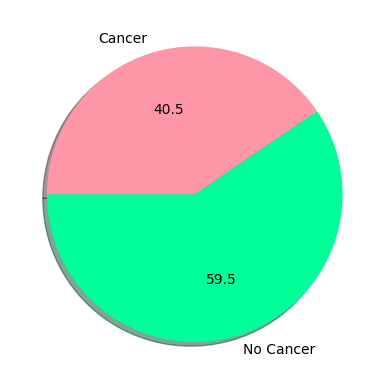

<Figure size 1600x1600 with 0 Axes>

In [ ]:
labels_count = full_train_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['No Cancer', 'Cancer'], startangle=180, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(16,16))
plt.show()

In [ ]:
from glob import glob 
import numpy as np
import pandas as pd
import keras,cv2,os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange
import matplotlib.pyplot as plt

import gc #garbage collection, we need to clean up and save memory
#set paths to training and test data
path = "/content/" #adapt this path, when running locally
train_path = path + 'train/'
test_path = path + 'test/'

df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0]) # keep only the file names in 'id'
labels = pd.read_csv(path+"train_labels.csv") # read the provided labels
df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(10) # print the first three entrys
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    y = np.squeeze(df.values)[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

df.shape

# Load 10k images
N=10000
X,y = load_data(N=N,df=df) 

<ipython-input-11-9497cd27f0ae>:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# Number of samples in each class
SAMPLE_SIZE = 80000

# Data paths
train_path = '/content/train/'
test_path = '/content/test/'

# Use 80000 positive and negative examples
df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

In [ ]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    # We the get the following mean and std for the channels of all the images
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
# Set Batch Size
batch_size = 128

# Percentage of training set to use as validation
valid_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    #transforms.Normalize((0.70244707, 0.54624322, 0.69645334), (0.23889325, 0.28209431, 0.21625058))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
sample_sub = pd.read_csv("/content/sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # Convolutional and Pooling Layers
        self.conv1=nn.Sequential(
                nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(
                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(
                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(
                nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2,2))
        
        self.dropout2d = nn.Dropout2d()
        
        
        self.fc=nn.Sequential(
                nn.Linear(512*3*3,1024),
                nn.ReLU(inplace=True),
                nn.Dropout(0.4),
                nn.Linear(1024,512),
                nn.Dropout(0.4),
                nn.Linear(512, 1),
                nn.Sigmoid())
        
    def forward(self,x):
        """Method for Forward Prop"""
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) <-- Life saving debugging step :D
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.cuda()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [ ]:
# Trainable Parameters
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6805249


In [ ]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [ ]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc))
    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.368355 | Validation Loss: 0.324501 | Validation AUC: 0.9416
Validation loss decreased (inf --> 0.324501).  Saving model ...
Epoch: 2 | Training Loss: 0.292227 | Validation Loss: 0.426367 | Validation AUC: 0.9438
Epoch: 3 | Training Loss: 0.262108 | Validation Loss: 0.230206 | Validation AUC: 0.9524
Validation loss decreased (0.324501 --> 0.230206).  Saving model ...
Epoch: 4 | Training Loss: 0.238344 | Validation Loss: 0.251256 | Validation AUC: 0.9569
Epoch: 5 | Training Loss: 0.219158 | Validation Loss: 0.208411 | Validation AUC: 0.9603
Validation loss decreased (0.230206 --> 0.208411).  Saving model ...
Epoch: 6 | Training Loss: 0.202789 | Validation Loss: 0.207800 | Validation AUC: 0.9633
Validation loss decreased (0.208411 --> 0.207800).  Saving model ...
Epoch: 7 | Training Loss: 0.193337 | Validation Loss: 0.188246 | Validation AUC: 0.9656
Validation loss decreased (0.207800 --> 0.188246).  Saving model ...
Epoch: 8 | Training Loss: 0.186094 | Validat

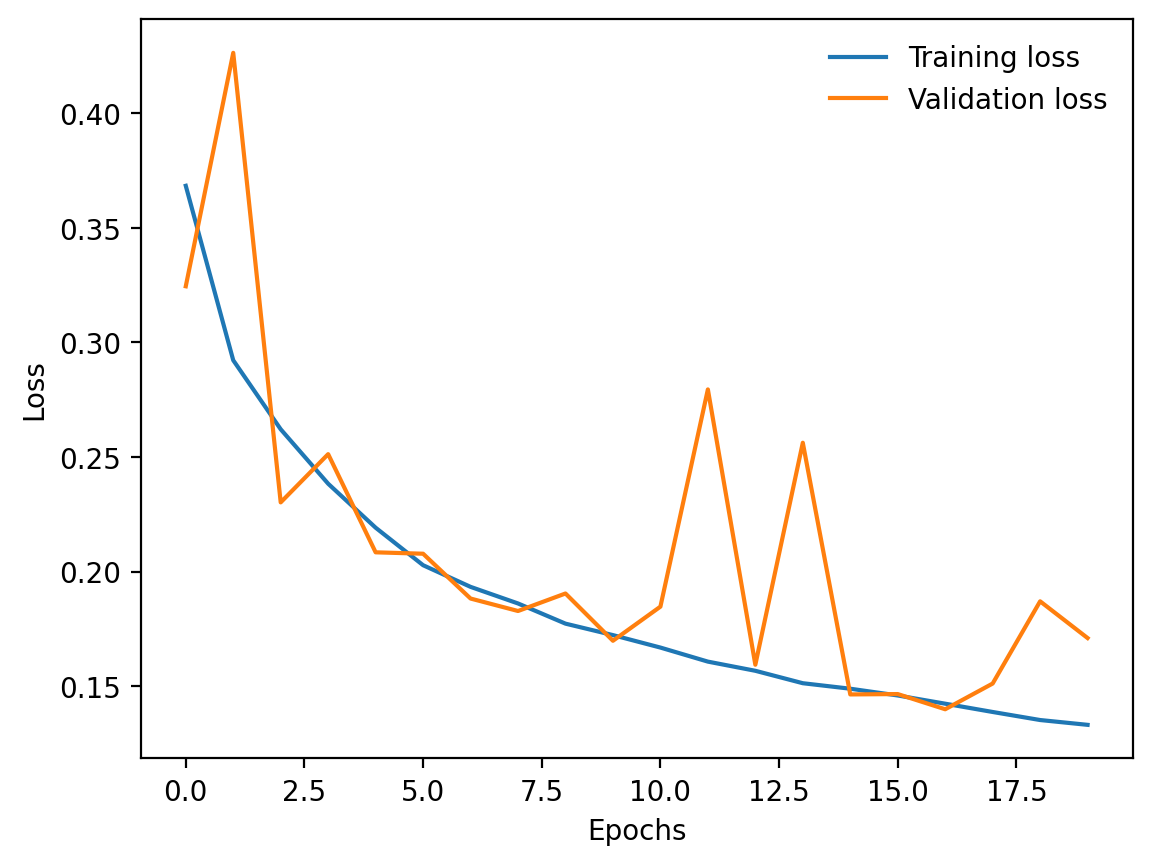

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

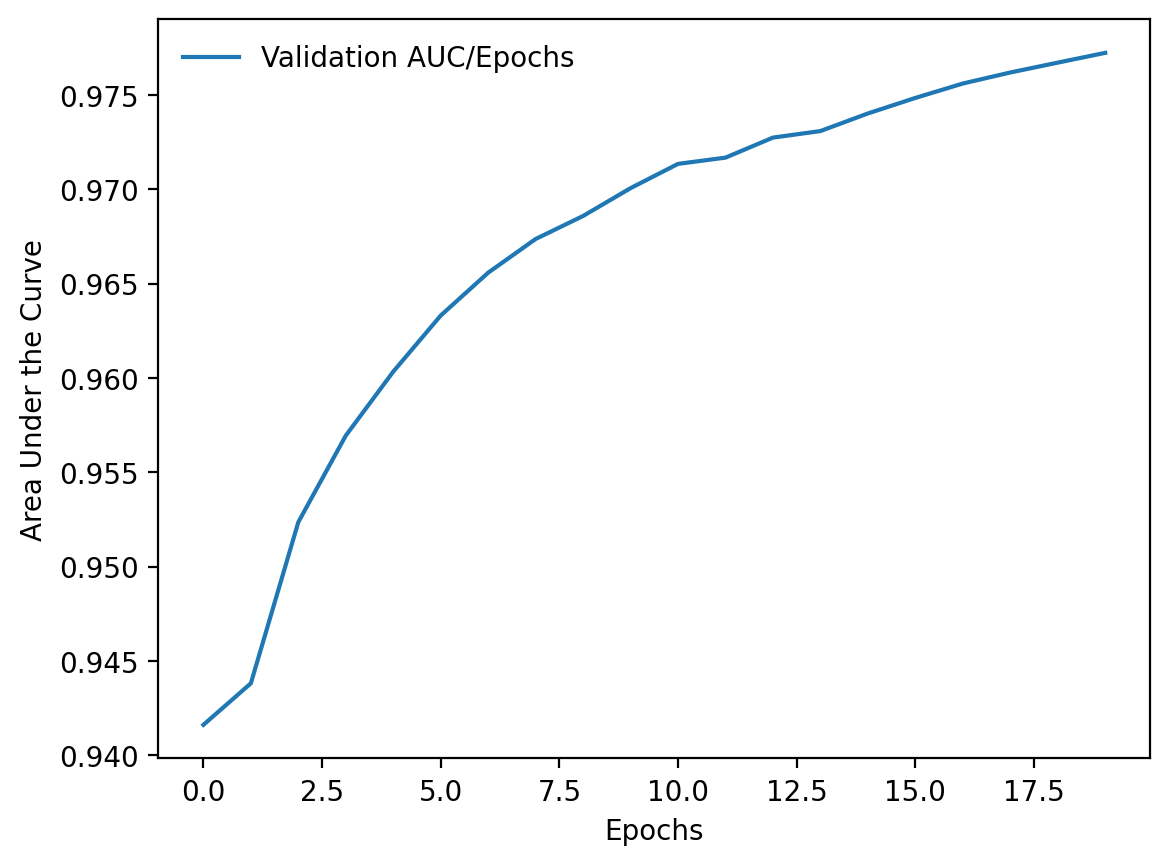

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)

#Second code



In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline
import sklearn

In [8]:
labels_df = pd.read_csv("train_labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [9]:
labels_df.shape

(220025, 2)

In [10]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [11]:
imgpath ="/train/" # training data is stored in this folder
malignant = labels_df.loc[labels_df['label']==1]['id'].values    # get the ids of malignant cases
normal = labels_df.loc[labels_df['label']==0]['id'].values       # get the ids of the normal cases

print('normal ids')
print(normal[0:3],'\n')

print('malignant ids')
print(malignant[0:3])

normal ids
['f38a6374c348f90b587e046aac6079959adf3835'
 '755db6279dae599ebb4d39a9123cce439965282d'
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08'] 

malignant ids
['c18f2d887b7ae4f6742ee445113fa1aef383ed77'
 'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da'
 '7f6ccae485af121e0b6ee733022e226ee6b0c65f']


In [12]:
torch.manual_seed(0) # fix random seed

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train"):      
    
        # Get Image File Names
        cdm_data=os.path.join(data_dir,data_type)  # directory of files
        
        file_names = os.listdir(cdm_data) # get list of images in that directory  
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      10000,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]   # get the full path to images
        
        # Get Labels
        labels_data=os.path.join(data_dir,"train_labels.csv") 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True) # set data frame index to id
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in file_names_sample]  # obtained labels from df
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames) # size of dataset
      
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  # Open Image with PIL
        image = self.transform(image) # Apply Specific Transformation to Image
        return image, self.labels[idx]

In [13]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((46,46))])

In [14]:
# Define an object of the custom dataset for the train folder.
data_dir = '/content/'
img_dataset = pytorch_data(data_dir, data_transformer, "train") # Histopathalogic images

In [15]:
# load an example tensor
img,label=img_dataset[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 46, 46]) tensor(0.0193) tensor(0.9965)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
len_img=len(img_dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_ts,val_ts=random_split(img_dataset,
                             [len_train,len_val]) # random split 80/20

print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))

train dataset size: 8000
validation dataset size: 2000


In [17]:
ii=-1
for x,y in train_ts:
    print(x.shape,y)
    ii+=1
    if(ii>5):
        break

torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 1
torch.Size([3, 46, 46]) 0
torch.Size([3, 46, 46]) 0


In [18]:
import plotly.express as px

def plot_img(x,y,title=None):

    npimg = x.numpy() # convert tensor to numpy array
    npimg_tr=np.transpose(npimg, (1,2,0)) # Convert to H*W*C shape
    fig = px.imshow(npimg_tr)
    fig.update_layout(template='plotly_white')
    fig.update_layout(title=title,height=300,margin={'l':10,'r':20,'b':10})
    fig.show()

In [19]:
# Define the following transformations for the training dataset
tr_transf = transforms.Compose([
    transforms.Resize((40,40)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
#     transforms.RandomResizedCrop(50,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()])

In [20]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToTensor()])

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
train_ts.transform=tr_transf
val_ts.transform=val_transf

In [21]:
# The subset can also have transform attribute (if we asign)
train_ts.transform

Compose(
    Resize(size=(40, 40), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
)

In [22]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=32, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=32,
                    shuffle=False)

In [23]:
# check samples
for x,y in train_dl:
    print(x.shape,y)
    break

torch.Size([32, 3, 46, 46]) tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1])


In [24]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)


In [25]:
import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [26]:
# Neural Network Predefined Parameters
params_model={
        "shape_in": (3,46,46), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

# Create instantiation of Network class
cnn_model = Network(params_model)

In [27]:
# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [28]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 46, 46),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 44, 44]             224
            Conv2d-2           [-1, 16, 20, 20]           1,168
            Conv2d-3             [-1, 32, 8, 8]           4,640
            Conv2d-4             [-1, 64, 2, 2]          18,496
            Linear-5                  [-1, 100]           6,500
            Linear-6                    [-1, 2]             202
Total params: 31,230
Trainable params: 31,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.19
Params size (MB): 0.12
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [29]:
loss_func = nn.NLLLoss(reduction="sum")

In [30]:
from torch import optim
opt = optim.SGD(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [31]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value
    
    return loss, metric

In [32]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.SGD(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}

In [33]:
from tqdm.notebook import trange, tqdm

def train_val(model, params,verbose=False):
    
    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # a deep copy of weights for the best performing model
    best_loss=float('inf') # initialize best loss to a large value
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model Process
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model Process
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [34]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

''' Actual Train / Evaluation of CNN Model '''
# train and validate the model

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Convergence History')

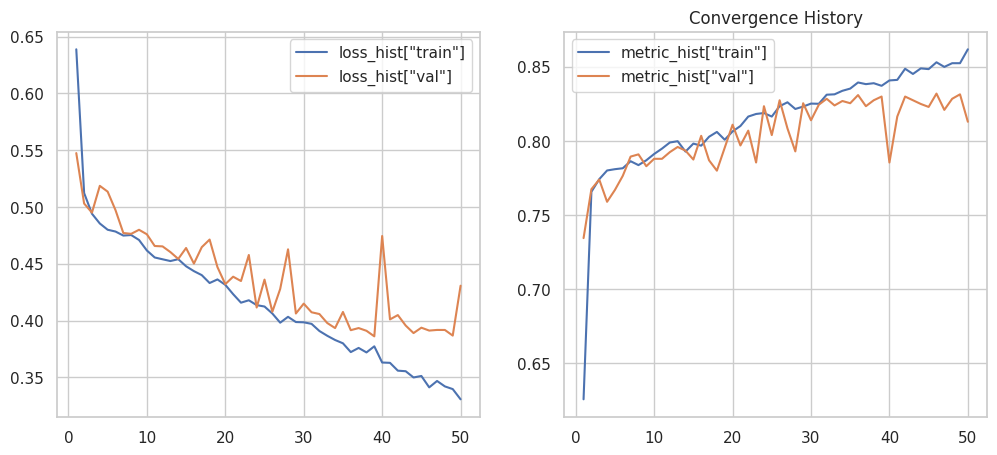

In [35]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')